# CMS GIWAXS plotting notebook - plotting single images from loaded zarr datasets
# A1-3 Sample Set

## Imports

In [2]:
# Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
from tqdm.auto import tqdm

# Choose a colormap:
cmap = plt.cm.turbo
cmap.set_bad('black')

## Define & check paths

In [3]:
def select_attrs(data_arrays_iterable, selected_attrs_dict):
    """
    Selects data arrays whose attributes match the specified values.

    Parameters:
    data_arrays_iterable: Iterable of xarray.DataArray objects.
    selected_attrs_dict: Dictionary where keys are attribute names and 
                         values are the attributes' desired values.

    Returns:
    List of xarray.DataArray objects that match the specified attributes.
    """    
    sublist = list(data_arrays_iterable)
    
    for attr_name, attr_values in selected_attrs_dict.items():
        sublist = [da for da in sublist if da.attrs[attr_name] in attr_values]
                
    return sublist

def fold_image(data_array, fold_axis, progress_bar=False):
    """
    Method to fold image along a specified axis.
    
    Parameters:
    - data_array (xarray DataArray): The DataArray to fold
    - fold_axis (str): The axis along which to fold the image
    
    Returns:
    - xarray DataArray: The folded image
    """
    # Filter data for fold_axis >= 0 and fold_axis <= 0
    positive_data = data_array.where(data_array[fold_axis] >= 0, drop=True)
    negative_data = data_array.where(data_array[fold_axis] <= 0, drop=True)
    
    # Reverse negative_data for easier comparison
    negative_data = negative_data.reindex({fold_axis: negative_data[fold_axis][::-1]})
    
    # Find the maximum coordinate of the shorter quadrant (positive_data)
    max_positive_coord = float(positive_data[fold_axis].max())
    
    # Find the equivalent coordinate in the negative_data
    abs_diff = np.abs(negative_data[fold_axis].values + max_positive_coord)
    
    # Minimize the difference
    min_diff_idx = np.argmin(abs_diff)
    
    # Check if the lengths are equivalent
    len_pos = len(positive_data[fold_axis])
    len_neg = len(negative_data[fold_axis][:min_diff_idx+1])
    
    if len_pos != len_neg:
        # Adjust the coordinate range for negative_data
        for i in range(1, 4):  # Check 3 neighbors
            new_idx = min_diff_idx + i
            len_neg = len(negative_data[fold_axis][:new_idx+1])
            if len_pos == len_neg:
                min_diff_idx = new_idx
                break
                
    # Crop the negative_data to match positive_data length
    negative_data_cropped = negative_data.isel({fold_axis: slice(0, min_diff_idx+1)})
    
    # Prepare the new data array
    new_data = xr.zeros_like(positive_data)
    
    # Fold the image
    if progress_bar:
        for i in tqdm(range(len(positive_data[fold_axis]))):
            pos_val = positive_data.isel({fold_axis: i}).values
            neg_val = negative_data_cropped.isel({fold_axis: i}).values

            # Pixel comparison and choosing 
            new_data[i] = np.where(((pos_val == 0) | (np.isnan(pos_val))) & (neg_val > 1-1e-6),
                                   neg_val, 
                                   pos_val)
    else:
        for i in range(len(positive_data[fold_axis])):
            pos_val = positive_data.isel({fold_axis: i}).values
            neg_val = negative_data_cropped.isel({fold_axis: i}).values

            # Pixel comparison and choosing 
            new_data[i] = np.where(((pos_val == 0) | (np.isnan(pos_val))) & (neg_val > 1-1e-6),
                                   neg_val, 
                                   pos_val) 
            
        # Pixel comparison and averaging
        # new_data[i] = np.where(
        #     (pos_val > 0) & (neg_val > 0), 
        #     (pos_val + neg_val) / 2,
        #     np.where(((pos_val == 0) | (np.isnan(pos_val))) & (neg_val > 0),
        #              neg_val, 
        #              pos_val)
        # )


        
    # Append residual data from the longer quadrant if exists
    if len(negative_data[fold_axis]) > min_diff_idx+1:
        residual_data = negative_data.isel({fold_axis: slice(min_diff_idx+1, None)})
        residual_data[fold_axis] = np.abs(residual_data[fold_axis])
        new_data = xr.concat([new_data, residual_data], dim=fold_axis)
        
    # Update data_array with the folded image
    data_array = new_data.sortby(fold_axis)
    
    # Inherit coordinates and metadata attributes from the original data_array
    data_array.attrs = data_array.attrs.copy()
    data_array.attrs['fold_axis'] = fold_axis  # Add 'fold_axis' attribute

    # Ensure all original coordinates are retained in the new data_array
    for coord in data_array.coords:
        if coord not in data_array.coords:
            data_array = data_array.assign_coords({coord: data_array[coord]})

    return data_array

In [4]:
# I like pathlib for its readability & checkability, it's also necessary for the loadSeries function later on
# Replace the paths with the ones relevant to your data, you can use the ".exists()" method to make sure you defined a path correctly
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')  # The proposals path is a good place to store large data (>1 TB space?)
outPath = propPath.joinpath('AL_processed_data')

samplesPath = outPath.joinpath('ex_situ_zarrs_v2/bcy651')

In [5]:
# List the files inside a folder
sorted([f.name for f in samplesPath.iterdir()])  # a way to list just the filenames and not the whole path

['A1-3set_caked_stitched.zarr',
 'A1-3set_raw_stitched.zarr',
 'A1-3set_recip_stitched.zarr']

## Cartesian plots

### Load dataset

In [6]:
filename = 'A1-3set_recip_stitched.zarr'
DS = xr.open_zarr(samplesPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

<xarray.Dataset>
Dimensions:  (q_z: 1043, q_xy: 981)
Coordinates:
  * q_xy     (q_xy) float64 -1.829 -1.825 -1.821 -1.817 ... 2.17 2.174 2.178
  * q_z      (q_z) float64 -1.61 -1.606 -1.602 -1.598 ... 2.528 2.532 2.536 2.54
Data variables: (12/30)
    1116580  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116581  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116582  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116586  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116587  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116588  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    ...       ...
    1116628  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116629  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116630  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116634  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116635  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>
    1116636  (q_z, q_xy) float64 dask.array<chunksize=(261, 246), meta=np.ndarray>

### 2D reciprocal space images

In [26]:
savePath

PosixPath('/nsls2/data/cms/proposals/2023-2/pass-311415/AL_processed_data/A1-3set_waxs/recip_plots_v1')

In [33]:
# 2D reciprocal space cartesian plots
qxy_min = -1.1
qxy_max = 2.1
qz_min = -0.001
qz_max = 2.2

savePath = outPath.joinpath('A1-3set_waxs/bcy651/recip_plots_v1')

selected_attrs_dict = {}
selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)

for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
    
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))   
    
    # Plot
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.axes.set(aspect='equal', title=f'Cartesian Plot: {DA.film}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.figure.set(tight_layout=True, dpi=130)
    
    ax.figure.savefig(savePath.joinpath(f'{DA.film}_qxy{qxy_min}to{qxy_max}_qz{qz_min}to{qz_max}_{DA.incident_angle}.png'), dpi=150)
    
    # plt.show()
    plt.close('all')

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# # A way to save data as csv files
# for DA in tqdm(DS.data_vars.values()):
#     # qxy columns, qz rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'cartesian-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

### Yoneda Check

In [34]:
def qz(wavelength, alpha_crit, alpha_incidents):
    qz_inv_meters = ((4 * np.pi) / (wavelength)) * (np.sin(np.deg2rad((alpha_incidents + alpha_crit)/2)))
    # qz_inv_meters = ((4 * np.pi) / (wavelength)) * (np.sin(np.deg2rad(alpha_crit)) + np.sin(np.deg2rad(alpha_incidents)))
    qz_inv_angstroms = qz_inv_meters / 1e10
    return qz_inv_angstroms


wavelength = 9.762535309700809e-11  # 12.7 keV

alpha_crit = 0.11  # organic film critical angle
alpha_incidents = np.array([0.1, 0.12, 0.14])

yoneda_angles = alpha_incidents + alpha_crit

qz(wavelength, alpha_crit, alpha_incidents)

array([0.02358922, 0.02583581, 0.0280824 ])

  0%|          | 0/3 [00:00<?, ?it/s]

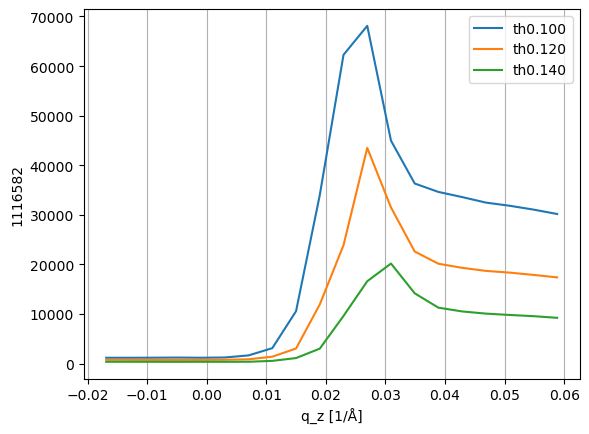

In [50]:
# Yoneda peak linecut check
qxy_min = 0.22
qxy_max = 2
qz_min = -0.02
qz_max = 0.06

selected_attrs_dict = {'film': ['D18p1']}
selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
    qz_integrated_DA = sliced_DA.sum('q_xy')
    
    # Plot
    qz_integrated_DA.plot.line(label=DA.incident_angle)
    
plt.legend()
plt.grid(visible=True, which='major', axis='x')
plt.show()
plt.close('all')

### 1D Qxy or Qz integrated lincuts

## Polar plots

### Load dataset

In [51]:
filename = 'A1-3set_caked_stitched.zarr'
DS = xr.open_zarr(samplesPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

<xarray.Dataset>
Dimensions:  (chi: 180, qr: 1000)
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.0009925 0.004228 0.007464 ... 3.227 3.23 3.234
Data variables: (12/30)
    1116580  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116581  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116582  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116586  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116587  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116588  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    ...       ...
    1116628  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116629  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116630  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116634  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116635  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1116636  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>

In [52]:
### Apply a sin chi correction
sin_chi_DA = np.sin(np.radians(np.abs(DS.chi)))

corr_DS = DS.copy()
# corr_DS = corr_DS * sin_chi_DA  # This works mathematically, but does not preserve attributes
for var in corr_DS.data_vars:
    corrected = corr_DS[var] * sin_chi_DA
    corr_DS[var].values = corrected.values
    
corr_DS

<xarray.Dataset>
Dimensions:  (chi: 180, qr: 1000)
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.0009925 0.004228 0.007464 ... 3.227 3.23 3.234
Data variables: (12/30)
    1116580  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116581  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116582  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116586  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116587  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116588  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ...       ...
    1116628  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116629  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116630  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116634  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116635  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1116636  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [53]:
### Fold sin(chi) corrected dataset

folded_corr_DAs = []
for DA in tqdm(corr_DS.data_vars.values()):
    folded_corr_DAs.append(fold_image(DA, 'chi'))

  0%|          | 0/30 [00:00<?, ?it/s]

### 2D caked images

#### Unfolded raw(chi) intensity

In [56]:
# Polar plots, for raw(chi) intensities

# Set chi range: Full range
chi_min = -90
chi_max = 90
q_min = None
q_max = None

savePath = outPath.joinpath('A1-3set_waxs/bcy651/caked_plots_v1')
    
selected_attrs_dict = {}
selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)

for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))
    
    # Set color limits
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))       
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.axes.set(title=f'Polar Plot: {DA.film}, {float(DA.incident_angle[2:])}° Incidence, Raw Intensity')
    ax.colorbar.set_label('Raw Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    # plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    ax.figure.savefig(savePath.joinpath(f'rawchi_{DA.film}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

  0%|          | 0/30 [00:00<?, ?it/s]

#### Folded raw(chi) intensity

In [ ]:
# Polar plots, for FOLDED raw(chi) intensities

# Set chi range: Full range
chi_min = None
chi_max = None
q_min = None
q_max = None

savePath = outPath.joinpath('A1-3set_waxs/caked_plots_v1')

selected_attrs_dict = {'film':['A3']}
selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
    
for DA in tqdm(selected_DAs):
    DA = fold_image(DA, 'chi')

    # Set color limits
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(DA.compute().quantile(0.995))  
    
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))     
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.axes.set(title=f'Folded Polar Plot: {DA.film}, {float(DA.incident_angle[2:])}° Incidence, Raw Intensity')
    ax.colorbar.set_label('Raw Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(savePath.joinpath(f'rawchi-folded_{DA.film}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

#### Unfolded sin(chi) intensity

In [ ]:
# Polar plots, for sin(chi) intensities

# Set chi range: Full range
chi_min = -90
chi_max = 90
q_min = None
q_max = None

savePath = outPath.joinpath('A1-3set_waxs/caked_plots_v1')
    
for DA in tqdm(selected_corr_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))
    
    # Set color limits
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))       
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.axes.set(title=f'Polar Plot: {DA.film}, {float(DA.incident_angle[2:])}° Incidence, sin($\chi$) Corrected')
    ax.colorbar.set_label('Intensity * sin($\chi$) [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(savePath.joinpath(f'sinchi_{DA.film}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

#### Folded sin(chi) intensity

In [64]:
# Polar plots, for FOLDED sin(chi) intensities

# Set chi range: Full range
chi_min = 10
chi_max = 82
q_min = 0.2
q_max = 2.04

# Set savePath
savePath = outPath.joinpath('A1-3set_waxs/bcy651/caked_plots_v1')

selected_attrs_dict = {}
selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
    
for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))
    
    # Set color limits
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))       
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(origin='upper', cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4))  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.axes.set(title=f'Folded polar plot: {DA.film}, $\\alpha_i$ = {float(DA.incident_angle[2:])}°, sin($\chi$) corrected')
    ax.colorbar.set_label('Intensity * sin($\chi$) [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    # plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    ax.figure.savefig(savePath.joinpath(f'sinchi-folded_{DA.film}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

  0%|          | 0/30 [00:00<?, ?it/s]

### 1D linecuts along chi

In [66]:
import matplotlib.ticker as ticker

In [67]:
import matplotlib.colors as mcolors

In [68]:
def darken_colors(color_array, factor):
    """
    Darken an array of RGB colors where 0 is white and 1 is black.
    
    :param color_array: An array of RGB colors in the range [0, 1] where 0 is white and 1 is black
    :param factor: A float between 0 and 1, where 0 has no change and 1 is fully black
    :return: The darkened color array
    """
    darkened_colors = color_array + (1 - color_array) * factor
    return np.clip(darkened_colors, 0, 1)  # Ensures values stay within valid range

In [75]:
# colors = plt.cm.tab20c_r(np.linspace(0,1,20))[:16][::2]  # for 2 incident angles
colors = plt.cm.tab20c_r(np.linspace(0,1,20))[:16]  # for 4 incident angles
colors = darken_colors(colors, -0.5)

In [102]:
colors

array([[0.77647059, 0.77647059, 0.77647059, 1.        ],
       [0.61176471, 0.61176471, 0.61176471, 1.        ],
       [0.38235294, 0.38235294, 0.38235294, 1.        ],
       [0.08235294, 0.08235294, 0.08235294, 1.        ],
       [0.78235294, 0.78235294, 0.88235294, 1.        ],
       [0.60588235, 0.61176471, 0.79411765, 1.        ],
       [0.42941176, 0.40588235, 0.67647059, 1.        ],
       [0.18823529, 0.12941176, 0.54117647, 1.        ],
       [0.67058824, 0.87058824, 0.62941176, 1.        ],
       [0.44705882, 0.77647059, 0.41176471, 1.        ],
       [0.18235294, 0.65294118, 0.19411765, 1.        ],
       [0.        , 0.45882353, 0.        , 1.        ],
       [0.98823529, 0.72352941, 0.45294118, 1.        ],
       [0.98823529, 0.52352941, 0.12941176, 1.        ],
       [0.98823529, 0.32941176, 0.        , 1.        ],
       [0.85294118, 0.        , 0.        , 1.        ]])

In [106]:
# Indices of rows to be deleted
indices_to_delete = [0, 4, 8, 12]

# Deleting the specified rows
arr_modified = np.delete(colors, indices_to_delete, axis=0)

In [108]:
arr_modified

array([[0.61176471, 0.61176471, 0.61176471, 1.        ],
       [0.38235294, 0.38235294, 0.38235294, 1.        ],
       [0.08235294, 0.08235294, 0.08235294, 1.        ],
       [0.60588235, 0.61176471, 0.79411765, 1.        ],
       [0.42941176, 0.40588235, 0.67647059, 1.        ],
       [0.18823529, 0.12941176, 0.54117647, 1.        ],
       [0.44705882, 0.77647059, 0.41176471, 1.        ],
       [0.18235294, 0.65294118, 0.19411765, 1.        ],
       [0.        , 0.45882353, 0.        , 1.        ],
       [0.98823529, 0.52352941, 0.12941176, 1.        ],
       [0.98823529, 0.32941176, 0.        , 1.        ],
       [0.85294118, 0.        , 0.        , 1.        ]])

/tmp/ipykernel_81612/2027960618.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(scalar_mappable, ticks=range(colors.shape[0]), spacing='proportional')


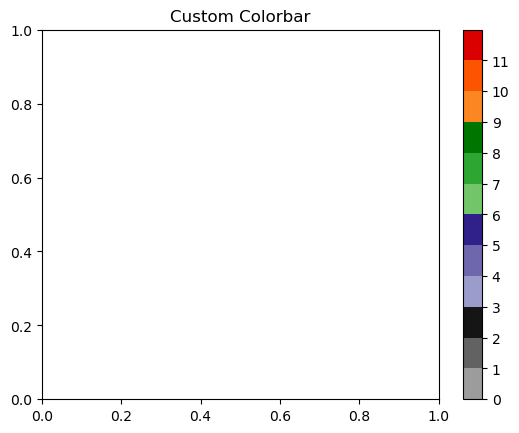

In [109]:
colors = arr_modified
# Create a custom colormap
custom_cmap = mcolors.ListedColormap(colors)

# Create a scalar mappable object with the normalization and colormap
norm = mcolors.Normalize(vmin=0, vmax=colors.shape[0])
scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap)

# Plot the colorbar
plt.colorbar(scalar_mappable, ticks=range(colors.shape[0]), spacing='proportional')
plt.title('Custom Colorbar')
plt.show()

In [146]:
# Set lims
oop_chi_min = 10
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 82

q_min = 0.1
q_max = 2.04
# q_min = 0.2
# q_max = 0.8

# Set savePath
savePath = outPath.joinpath('A1-3set_waxs/bcy651/stacked_linecut_plots_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140'],
#                        'material':['Y6']}
# selected_attrs_dict = {'material':['Y7']}
selected_attrs_dict = {}

# group_size = 2
# group_size = 4
group_size = 3

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
DA_sublists = [selected_DAs[i:i + group_size] for i in range(0, len(selected_DAs), group_size)]

# colors = plt.cm.tab20c_r(np.linspace(0,1,20))[:16][::2]  # for 2 incident angles
colors = plt.cm.tab20c_r(np.linspace(0,1,20))[:16]  # for 4 incident angles
colors = darken_colors(colors, -0.5)

indices_to_delete = [0, 4, 8, 12]  # for 3 incident angles
colors = np.delete(colors, indices_to_delete, axis=0)

for DA_sublist in tqdm(DA_sublists):
    # Sort by incident angle:
    DA_sublist = sorted(DA_sublist, key = lambda x: x.incident_angle)
    
    # Define the figure and subplots
    fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True, dpi=120)

    # Adjust the spacing between plots
    fig.subplots_adjust(hspace=0.005)  # Adjust this value as needed to minimize white space
    
    for i, DA in enumerate(DA_sublist):        
        # Plotting each line in its subplot
        # OOP
        OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(oop_chi_max - oop_chi_min)
        OOP_linecut_DA.plot.line(color=colors[i], ax=axs[0], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

        # Diagonal
        Diagonal_linecut_DA = DA.sel(chi=slice(oop_chi_max, ip_chi_min), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_min - oop_chi_max)
        Diagonal_linecut_DA.plot.line(color=colors[i+(group_size*1)], ax=axs[1], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

        # IP
        IP_linecut_DA = DA.sel(chi=slice(ip_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_max - ip_chi_min)
        IP_linecut_DA.plot.line(color=colors[i+(group_size*2)], ax=axs[2], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

        # Full
        Full_linecut_DA = DA.sel(chi=slice(oop_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / 90
        Full_linecut_DA.plot.line(color=colors[i+(group_size*3)], ax=axs[3], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

    # Add legends and gridlines to each subplot
    for ax in axs:
        ax.grid(True, which='major', axis='x')  # Add gridlines
        ax.xaxis.set_major_locator(ticker.AutoLocator())  # Set major tick locator
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Set minor tick locator
        ax.set_ylabel('')

    axs[0].text(0.5, 0.88, f'Out-of-plane, {oop_chi_min}-{oop_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='center', transform=axs[0].transAxes)
    axs[1].text(0.5, 0.88, f'Diagonal, {oop_chi_max}-{ip_chi_min}°' + r' $\chi$', fontsize=12,
                horizontalalignment='center', transform=axs[1].transAxes)
    axs[2].text(0.5, 0.88, f'In-plane, {ip_chi_min}-{ip_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='center', transform=axs[2].transAxes)
    axs[3].legend(loc='upper center', title=f'Full, {oop_chi_min}-{ip_chi_max}°' + r' $\chi$',
                  fontsize=10, title_fontsize='large')
       

    # Add axis labels
    axs[-1].set_xlabel('$q_r$ $[Å^{-1}]$', fontsize=12)
    fig.text(0.01, 0.5, 'Integrated intensities [arb. units]', va='center', rotation='vertical', fontsize=12)

    # fig.suptitle(f'{DA.material} {DA.solvent}: $\\chi$-integrated linecuts, $\\chi$-width normed', y=0.91, fontsize=14)
    fig.suptitle(f'{DA.film} $\\chi$-integrated linecuts, $\\chi$-width normed', y=0.91, fontsize=14)

    # fig.savefig(savePath.joinpath(f'sinchi-folded_{DA.film}_q{q_min}to{q_max}.png'), dpi=150, bbox_inches='tight')

    # plt.show()
    plt.close('all')

  0%|          | 0/10 [00:00<?, ?it/s]

In [115]:
# Set lims
oop_chi_min = 8
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 87

q_min = None
q_max = 2.04

# Set savePath
savePath = outPath.joinpath('A1-3set_waxs/bcy651/linecut_plots_v1')

selected_attrs_dict = {}
selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)

for DA in tqdm(selected_DAs):
    # OOP
    OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(q_min,q_max)).integrate('chi')
    OOP_linecut_DA.plot.line(figsize=(6,4), label=f'Out-of-plane, {oop_chi_min} to {oop_chi_max}°' + r' $\chi$')

    # A plot.line xarray plot does not return an AxesImage object like imshow does
    # Can use plt.gca() and plt.gcf() to access the axes & figure parameters
    ax = plt.gca()
    fig = plt.gcf()

    # IP
    ax2 = ax.twinx()
    IP_linecut_DA = DA.sel(chi=slice(ip_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi')
    IP_linecut_DA.plot.line(color='C1', ax=ax2, label=f'In-plane, {ip_chi_min} to {ip_chi_max}°' + r' $\chi$')
    
    ax.set(title=f'{DA.film} 22° Linecuts, {float(DA.incident_angle[2:])}° Incidence',
           ylabel='Out-of-plane Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
    ax2.set(ylabel='In-plane Intensity [arb. units]')
    
    ax.grid(visible=True, which='major', axis='x')
    fig.set(tight_layout=True, dpi=130)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1))
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.91)) 
    
    ax.figure.savefig(savePath.joinpath(f'sinchi-folded_{DA.film}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)

    # plt.show()
    plt.close('all')

  0%|          | 0/30 [00:00<?, ?it/s]

### 1D line fitting*
Use lmfit to perform the linefits

In [116]:
from scipy import optimize, signal
from lmfit import models

In [208]:
def fit_plotter(q, I, out):
    """
    Plots a figure with 2 axes, the full fit on a log scale on the left and the components in normal scale on the right
    """
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set(size_inches=(12,4))
    
    ax1.plot(q, I, label='data')
    ax1.plot(q, out.best_fit, label=f'full_fit, $R^2$={np.round(out.rsquared, 2)},' + r' $\chi^2_{red}$=' + f'{np.round(out.redchi, 1)}')
    ax1.set(xlabel='Q [Å$^{-1}$]', ylabel='Intensity [arb. units]')
    ax1.legend(loc='upper left')
    
    ax2.plot(q, I, label='data')
    ax2.plot(q, out.best_fit, label='full_fit')
    for key in out.eval_components():
        ax2.plot(q, out.eval_components()[key], label=f'{key}')
    ax2.set(xlabel='Q [Å$^{-1}$]')
    ax2.legend(loc='upper left')
    
    return (ax1, ax2), fig

In [118]:
# chi_min = 8
# chi_max = 18

# q_min = 1.1
# q_max = 2.45

# # points_x = [0.3, 2.6]

# point_x = q_min


# for DA in folded_corr_DAs:
#     point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
#     point_y = point_y - point_y*(0.08)


#     DA.sel(chi=slice(chi_min, chi_max), qr=slice(q_min, q_max)).plot()
#     plt.show()

#     OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(q_min, q_max)).mean('chi')
#     OOP_linecut_DA.plot()

#     plt.hlines(point_y, xmin=q_min, xmax=q_max)

#     plt.show()
#     plt.close('all')

#### Messy line fitting below

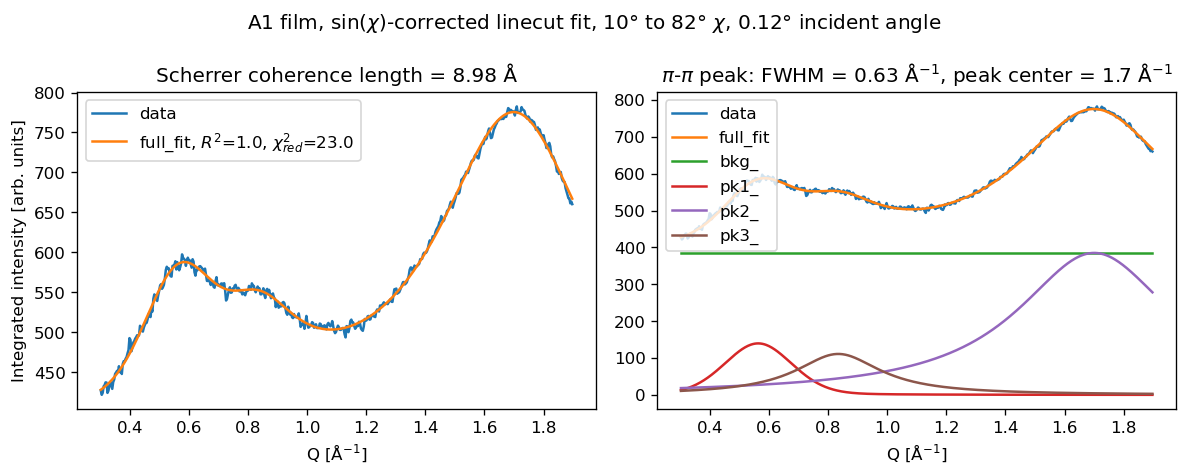

FWHM = 0.63, Lc = 8.98



{'pk3_amplitude': 61.29017673316513,
 'pk3_center': 0.834150446276512,
 'pk3_sigma': 0.1755397724711465,
 'pk3_fraction': 0.9999999902475845,
 'pk2_amplitude': 381.6357566241335,
 'pk2_center': 1.7001422029056723,
 'pk2_sigma': 0.31733379874645395,
 'pk2_fraction': 0.9868964800261838,
 'pk1_amplitude': 42.79627563078849,
 'pk1_center': 0.5632142039795868,
 'pk1_sigma': 0.1343771883853524,
 'pk1_fraction': 0.20384996448643344,
 'bkg_slope': 0.0,
 'bkg_intercept': 385.677805610163}

In [210]:
### A1

# Set lims
oop_chi_min = 10
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 82

q_min = 0.1
q_max = 2.04
# q_min = 0.2
# q_max = 0.8

# Set savePath
savePath = outPath.joinpath('A1-3set_waxs/bcy651/line_fits_v1')

selected_attrs_dict = {'film': ['A1']}
selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)


DA = selected_DAs[1].copy()

OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(0.3, 1.9)).integrate('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').integrate('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)
pars['pk1_amplitude'].set(min=0)

# pk2_mod = models.LorentzianModel(prefix='pk2_')
pk2_mod = models.PseudoVoigtModel(prefix='pk2_')

pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
pars['pk2_amplitude'].set(min=0)

pk3_mod = models.PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(y, x, center=0.8)
pars['pk3_center'].set(max=0.9, min = 0.7)
pars['pk3_amplitude'].set(min=0)


# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(size_inches=(10,4), tight_layout=True, dpi=120)

axs[0].set(ylabel=f'Integrated intensity [arb. units]', title=f'Scherrer coherence length = {Lc} Å')
axs[1].set(title=f'$\pi$-$\pi$ peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'peak center = {center}' + ' Å$^{-1}$')
fig.suptitle(f'{DA.film} film, sin($\chi$)-corrected linecut fit, {chi_min}° to {chi_max}° $\chi$, {DA.incident_angle[2:-1]}° incident angle')    

# fig.savefig(savePath.joinpath(f'{DA.film}_{intensity_type}_{DA.incident_angle}_{oop_chi_min}to{oop_chi_max}chi.png'), dpi=120)
plt.show()
plt.close('all')


print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)

  0%|          | 0/6 [00:00<?, ?it/s]

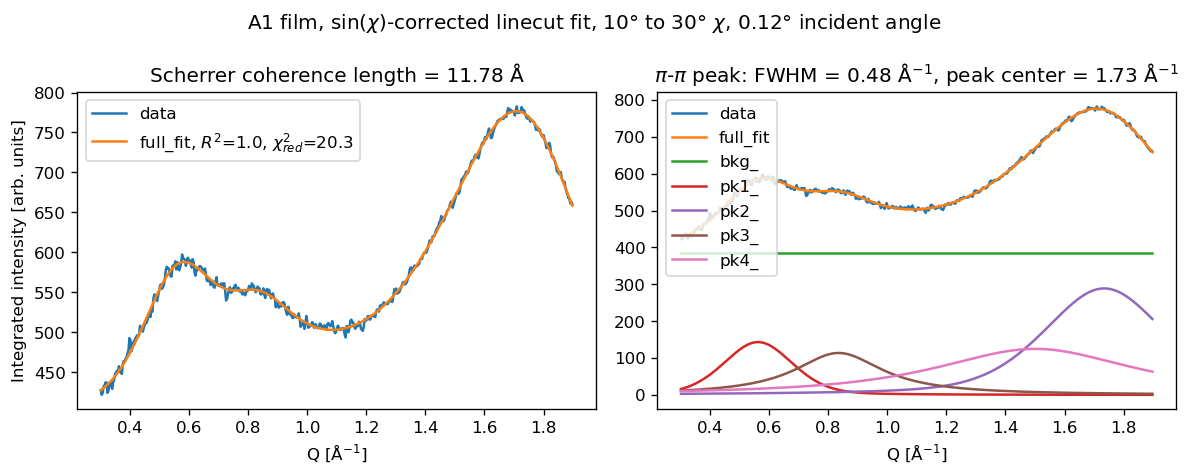

0.1818904963641056


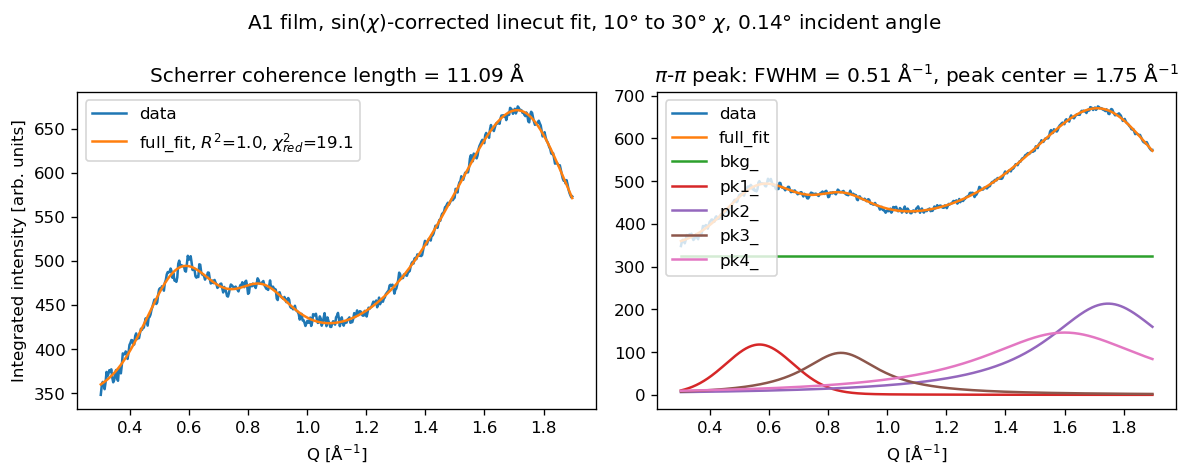

0.1589289802976945


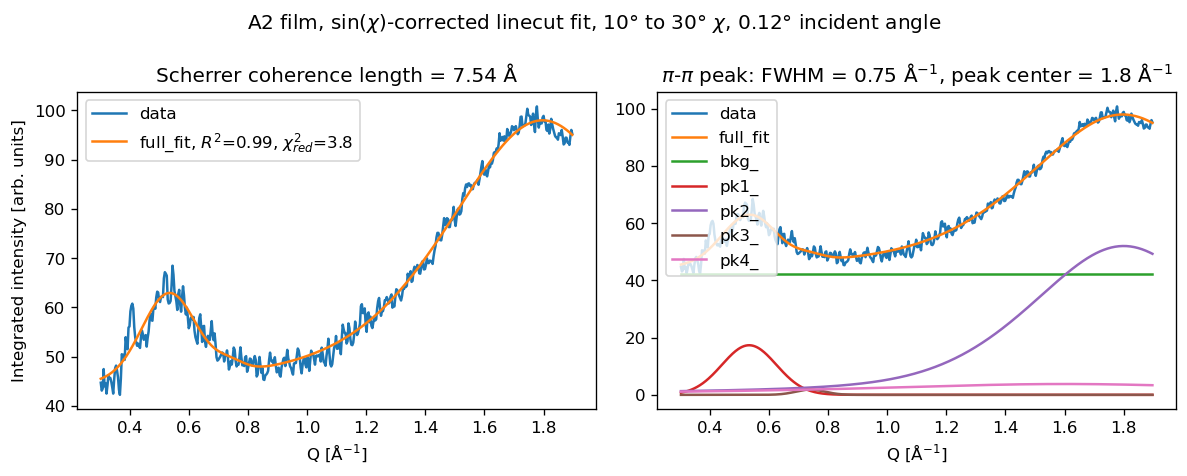

0.058267853193868804


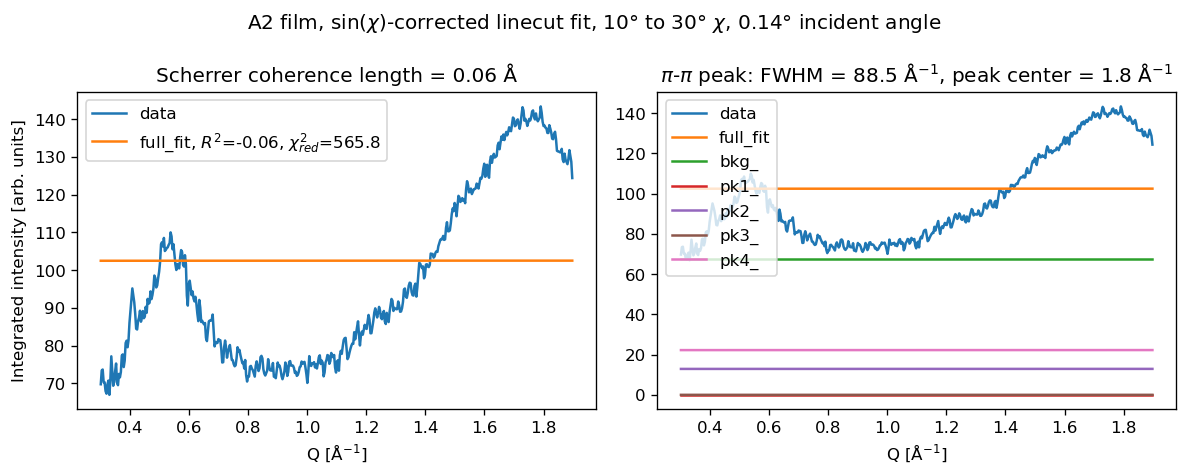

0.033463720018801234


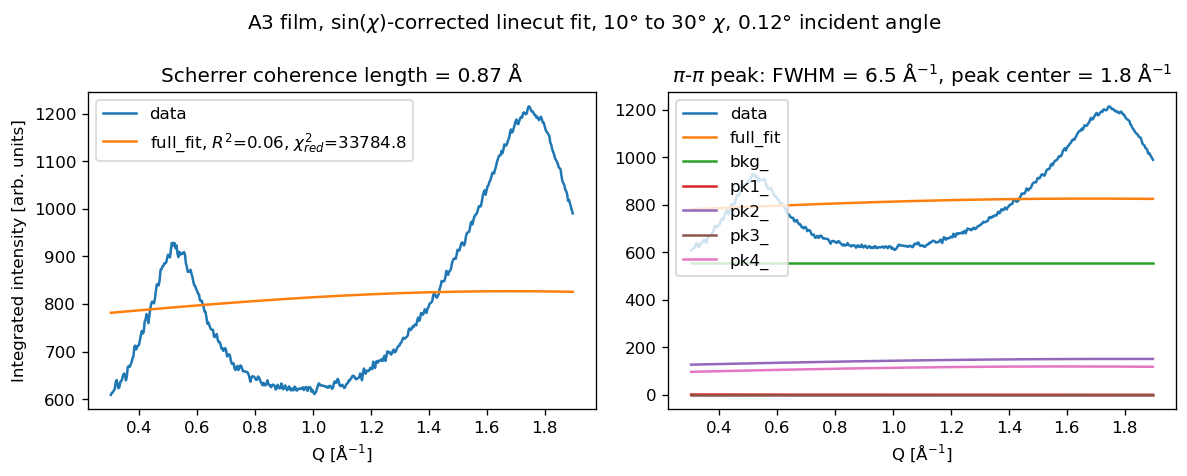

0.196816558939797


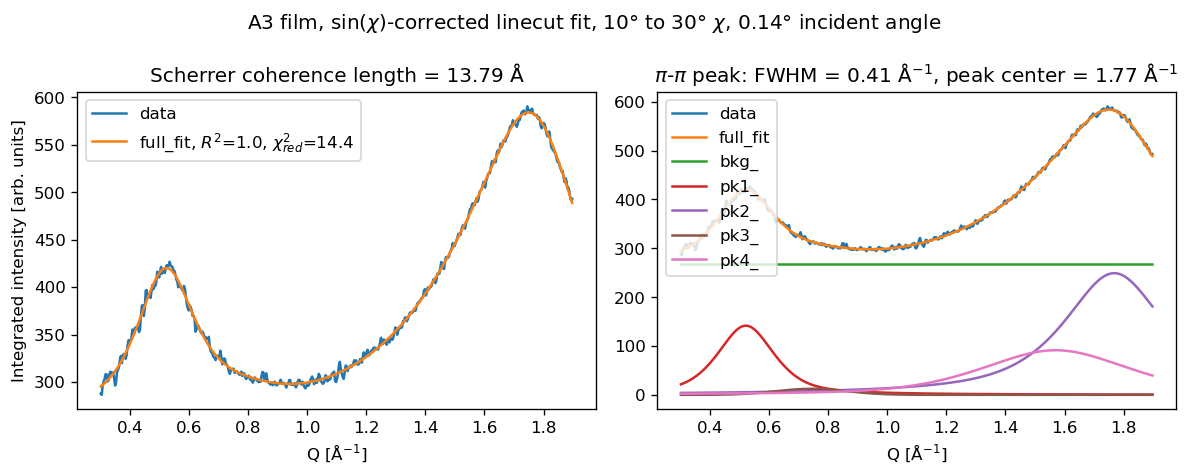

0.14072268748608247


In [261]:
### A1

# Set lims
oop_chi_min = 10
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 82

q_min = 0.1
q_max = 2.04
# q_min = 0.2
# q_max = 0.8

# Set savePath
savePath = outPath.joinpath('A1-3set_waxs/bcy651/line_fits_v1')

selected_attrs_dict = {'film': ['A1', 'A2', 'A3'], 'incident_angle': ['th0.120', 'th0.140']}
selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)

for DA in tqdm(selected_DAs):
    # DA = selected_DAs[-1].copy()

    OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(0.3, 1.9)).integrate('chi').dropna(dim='qr')

    point_x = 0.3
    point_y = float(DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').integrate('chi'))
    point_y = point_y - point_y*(0.08)

    x = OOP_linecut_DA.qr.data
    y = OOP_linecut_DA.data

    # Define all models to include in fitting
    bkg_mod = models.LinearModel(prefix='bkg_')
    pars = bkg_mod.make_params()
    pars = bkg_mod.make_params(intercept=point_y, slope=0)
    pars['bkg_intercept'].set(vary=False)
    pars['bkg_slope'].set(vary=False)

    pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
    # pars = pk1_mod.make_params(center=0.55)
    pars += pk1_mod.guess(y, x, center=0.55)
    # pars['pk1_amplitude'].set(min=0.5)
    pars['pk1_amplitude'].set(min=0)

    # pk2_mod = models.LorentzianModel(prefix='pk2_')
    pk2_mod = models.PseudoVoigtModel(prefix='pk2_')

    pars += pk2_mod.guess(y, x, center=1.7)
    pars['pk2_center'].set(max=1.8, min=1.69)
    # pars['pk2_sigma'].set(max = 0.03)
    pars['pk2_amplitude'].set(min=50)

    pk3_mod = models.PseudoVoigtModel(prefix='pk3_')
    pars += pk3_mod.guess(y, x, center=0.8)
    pars['pk3_center'].set(max=0.9, min = 0.7)
    pars['pk3_amplitude'].set(min=0)
    pars['pk3_sigma'].set(max=0.2)

    pk4_mod = models.PseudoVoigtModel(prefix='pk4_')
    pars += pk4_mod.guess(y, x, center=1.55)
    pars['pk4_center'].set(max=1.6, min=1.5)
    pars['pk4_amplitude'].set(min=10)
    
    # pk5_mod = models.PseudoVoigtModel(prefix='pk5_')
    # pars += pk5_mod.guess(y, x, center=1.22)
    # pars['pk5_center'].set(max=1.28, min=1.18)
    # pars['pk5_amplitude'].set(min=0, max=20)

    # Combine into full model
    mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod + pk4_mod  # + pk5_mod

    # Run fit and store all info in a ModelResult object
    out = mod.fit(y, pars, x=x)
    FWHM = np.round(float(out.params['pk2_fwhm']), 2)
    center = np.round(float(out.params['pk2_center']), 2)
    Lc = np.round((2*np.pi*0.9)/FWHM, 2)

    # Plot
    axs, fig = fit_plotter(x, y, out)
    fig.set(size_inches=(10,4), tight_layout=True, dpi=120)

    axs[0].set(ylabel=f'Integrated intensity [arb. units]', title=f'Scherrer coherence length = {Lc} Å')
    axs[1].set(title=f'$\pi$-$\pi$ peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'peak center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} film, sin($\chi$)-corrected linecut fit, {oop_chi_min}° to {oop_chi_max}° $\chi$, {DA.incident_angle[2:-1]}° incident angle')    

    # fig.savefig(savePath.joinpath(f'{DA.film}_{intensity_type}_{DA.incident_angle}_{oop_chi_min}to{oop_chi_max}chi.png'), dpi=120)
    plt.show()
    plt.close('all')


    # print(f'FWHM = {FWHM}, Lc = {Lc}\n')
    # display(out.best_values)
    print(out.best_values['pk3_sigma'])

In [258]:
out.best_values

{'pk4_amplitude': 81.42474385860105,
 'pk4_center': 1.5999999999911394,
 'pk4_sigma': 0.303806729519136,
 'pk4_fraction': 0.540015699382639,
 'pk3_amplitude': 3.776897066861724,
 'pk3_center': 0.7425930072275002,
 'pk3_sigma': 0.1426927420458195,
 'pk3_fraction': 3.295579920070679e-10,
 'pk2_amplitude': 140.3474249021429,
 'pk2_center': 1.7690603048356035,
 'pk2_sigma': 0.20285044761229165,
 'pk2_fraction': 0.8901169615279666,
 'pk1_amplitude': 43.47230177584142,
 'pk1_center': 0.5213419662347504,
 'pk1_sigma': 0.11297111369539081,
 'pk1_fraction': 0.672571493077934,
 'bkg_slope': 0.0,
 'bkg_intercept': 267.68692942532033}

In [259]:
out.best_values['pk3_sigma']

0.1426927420458195

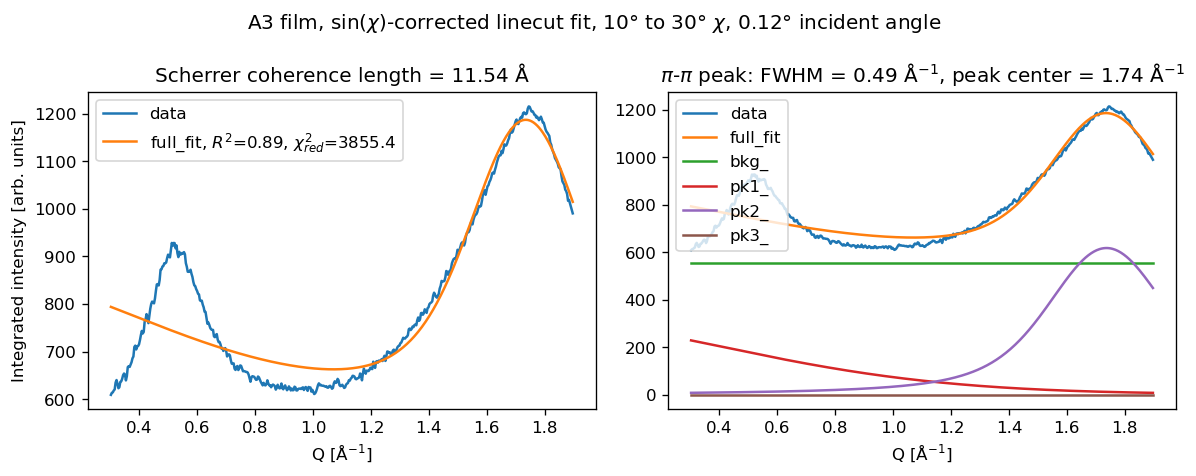

{'pk3_amplitude': 0.27947367799274736,
 'pk3_center': 2.2272965735894306,
 'pk3_sigma': 1.064198133495696,
 'pk3_fraction': 0.7442619729306603,
 'pk2_amplitude': 401.6727249742324,
 'pk2_center': 1.7369869861735139,
 'pk2_sigma': 0.13552933533495626,
 'pk2_gamma': 0.13552933533495626,
 'pk1_amplitude': 675.4764580270069,
 'pk1_center': -0.3661184523917338,
 'pk1_sigma': 0.9193050660615993,
 'pk1_fraction': 0.1154967451238279,
 'bkg_slope': 0.0,
 'bkg_intercept': 555.9613538938509}

In [245]:
### A3

# Set lims
oop_chi_min = 10
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 82

q_min = 0.1
q_max = 2.04
# q_min = 0.2
# q_max = 0.8

# Set savePath
savePath = outPath.joinpath('A1-3set_waxs/bcy651/line_fits_v1')

selected_attrs_dict = {'film': ['A3']}
selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)


DA = selected_DAs[1].copy()

OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(0.3, 1.9)).integrate('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').integrate('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)
pars['pk1_amplitude'].set(min=0)

# pk2_mod = models.PseudoVoigtModel(prefix='pk2_')
# pk2_mod = models.LorentzianModel(prefix='pk2_')
pk2_mod = models.VoigtModel(prefix='pk2_')
pars += pk2_mod.guess(y, x, center=1.7)
pars['pk2_center'].set(max=1.8, min=1.68)
pars['pk2_amplitude'].set(min=0)

pk3_mod = models.PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(y, x, center=0.8)
# pars['pk3_center'].set(max=0.9, min = 0.7)
pars['pk3_amplitude'].set(min=0)

# pk4_mod = models.PseudoVoigtModel(prefix='pk4_')
# pars += pk4_mod.guess(y, x, center=1.25)
# # pars['pk4_center'].set(max=0.9, min = 0.7)
# pars['pk4_amplitude'].set(min=0)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod  # + pk4_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(size_inches=(10,4), tight_layout=True, dpi=120)

axs[0].set(ylabel=f'Integrated intensity [arb. units]', title=f'Scherrer coherence length = {Lc} Å')
axs[1].set(title=f'$\pi$-$\pi$ peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'peak center = {center}' + ' Å$^{-1}$')
fig.suptitle(f'{DA.film} film, sin($\chi$)-corrected linecut fit, {oop_chi_min}° to {oop_chi_max}° $\chi$, {DA.incident_angle[2:-1]}° incident angle')    

# fig.savefig(savePath.joinpath(f'{DA.film}_{intensity_type}_{DA.incident_angle}_{oop_chi_min}to{oop_chi_max}chi.png'), dpi=120)
plt.show()
plt.close('all')


display(out.best_values)

In [200]:
out.redchi

20.320860334819447

In [201]:
out.rsquared

0.9978105994844646

In [199]:
# list(out.summary().keys())
out.summary()

{'model': "((((Model(linear, prefix='bkg_') + Model(pvoigt, prefix='pk1_')) + Model(pvoigt, prefix='pk2_')) + Model(pvoigt, prefix='pk3_')) + Model(pvoigt, prefix='pk4_'))",
 'method': 'leastsq',
 'ndata': 494,
 'nvarys': 16,
 'nfree': 478,
 'chisqr': 9713.371240043696,
 'redchi': 20.320860334819447,
 'aic': 1503.4892491561789,
 'bic': 1570.7298174311857,
 'rsquared': 0.9978105994844646,
 'nfev': 9613,
 'max_nfev': 34000,
 'aborted': False,
 'errorbars': True,
 'success': True,
 'message': 'Fit succeeded.',
 'lmdif_message': 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000',
 'ier': 1,
 'nan_policy': 'raise',
 'scale_covar': True,
 'calc_covar': True,
 'ci_out': None,
 'col_deriv': False,
 'flatchain': None,
 'call_kws': {'Dfun': None,
  'full_output': 1,
  'col_deriv': 0,
  'ftol': 1.5e-08,
  'xtol': 1.5e-08,
  'gtol': 0.0,
  'maxfev': 68000,
  'epsfcn': 1e-10,
  'factor': 100,
  'diag': None},
 'var_names': ['pk1_amplitude',
  'pk1_center',

In [185]:
# A3
intensity_type = 'raw'
if intensity_type == 'corr':
    DA = selected_corr_DAs[2].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[2].compute()
else:
    print('Must select intensity type')
    
OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)

pk2_mod = models.PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
# pars['pk2_amplitude'].set(min=0.5)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()

print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)


NameError: name 'selected_raw_DAs' is not defined

In [184]:
# list(out.summary().keys())
out.summary()['message']

'Fit succeeded.'

### Pole Figures

#### Pi-pi 

In [ ]:
### Set limits
q_max = 2.4
q_min = 1.1
chi_min = 8
chi_max = 87  # to ~45 least until I mask out the silicon(?) background scattering that interferes

### Set savePath
savePath = outPath.joinpath('A1-3set_waxs/pipi_pole_figures_v1')

### Select dataarrays to plot

# selected_attrs_dict = {'film':['A2', 'A1', 'A3'],
#                        'incident_angle':['th0.120']}
# selected_attrs_dict = {'film':['D18p1', 'D18A1p1', 'D18A2p1', 'D18A3'],
#                        'incident_angle':['th0.140']}
selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
 
peak_areas_dict = {}    
for DA in tqdm(selected_DAs):
    chis = DA.chi.sel(chi=slice(chi_min,chi_max)).data
    
    peak_areas = np.array([])
    peak_centers = np.array([])
    
    for chi in chis:
        sliced_DA = DA.sel(qr=slice(q_min, q_max), chi=float(chi))

        points_x = [q_min+0.05, q_max-0.05]
        points_y = [float(sliced_DA.sel(qr=slice(points_x[0]-0.05, points_x[0]+0.05)).mean('qr')), 
                    float(sliced_DA.sel(qr=slice(points_x[1]-0.2, points_x[1]+0.2)).mean('qr'))]
        m = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
        b = points_y[1] - (m*points_x[1])
        y_fit = np.polyval([m, b], sliced_DA.qr)
        
        sub_sliced_DA = sliced_DA-y_fit

        peak_area = sub_sliced_DA.sel(qr=slice(1.5,1.8)).integrate('qr')
        peak_area = np.nan if peak_area<0 else peak_area  # remove negatives as they are nonphysical
        
        peak_areas = np.append(peak_areas, float(peak_area))
                        
#         # Plot linecuts for each chi
#         fig, ax = plt.subplots()
#         sliced_DA.plot(ax=ax)
#         ax.plot(points_x, points_y)
#         plt.show()

#         plt.close('all')

    normed_peak_areas = peak_areas / np.nansum(peak_areas)
    data = np.vstack((chis, normed_peak_areas)).T
    peak_areas_dict[DA.attrs['film']+'-'+DA.attrs['incident_angle']] = data

    # Individual measurement pole figure plot
    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    ax.plot(chis, normed_peak_areas)
    fig.suptitle(f'{DA.film} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)
    ax.set(title=f'{q_min} to {q_max} 1/Å Q Bounds; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Integrated Pi-Pi Peak Area [arb. units]')
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    
    # fig.savefig(savePath.joinpath(f'{DA.film}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    
    # plt.show()
    
    plt.close('all')

In [ ]:
### Set savePath
savePath = outPath.joinpath('A1-3set_waxs/pipi_pole_figures_v1')

for th in tqdm(['th0.100', 'th0.120', 'th0.140']):
    selected_dict_items = [(name, data) for (name, data) in peak_areas_dict.items() if 
                           # name.split('-')[0] in ['D18p1', 'D18A1p1', 'D18A2p1', 'D18A3'] and 
                           # name.split('-')[0] in ['D18p2', 'D18A1p2', 'D18A2p2', 'D18A3'] and 
                           # name.split('-')[0] in ['A1', 'A2', 'A3'] and 
                           'D18' in name and
                           th in name]    

    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    colors = plt.cm.Dark2(np.linspace(0,1,len(selected_dict_items)))

    for i, (measurement, pole_fig_arr_data) in enumerate(selected_dict_items):
        chis = pole_fig_arr_data[:,0]
        normed_peak_areas = pole_fig_arr_data[:,1]
        ax.plot(chis, normed_peak_areas, color=colors[i], label=measurement)
        fig.suptitle('Pole Figure', x=0.55)
        ax.set(title=f'{q_min} to {q_max} 1/Å Q Fit Region; {chi_min}° to {chi_max}° $\chi$')
        ax.set(xlabel='$\chi$ [°]', ylabel='Normalized Peak Area')
    
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    ax.legend(loc='upper right')
    
    # fig.savefig(savePath.joinpath(f'multiple-D18all_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-D18p1s_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-D18p2s_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-A123_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)

    
    plt.show()
    plt.close('all')

#### Lamella

In [ ]:
### Set limits
q_min = 0.24
q_max = 0.5
chi_min = 2
chi_max = 87  # to ~45 least until I mask out the silicon(?) background scattering that interferes

### Set savePath
savePath = outPath.joinpath('A1-3set_waxs/lamella_pole_figures_v1')

### Select dataarrays to plot

# selected_attrs_dict = {'film':['A2', 'A1', 'A3'],
#                        'incident_angle':['th0.120']}
# selected_attrs_dict = {'film':['D18p1', 'D18A1p1', 'D18A2p1', 'D18A3'],
#                        'incident_angle':['th0.140']}
# selected_attrs_dict = {'film':['D18p1'],
#                        'incident_angle':['th0.120']}
selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
 
peak_areas_dict = {}    
for DA in tqdm(selected_DAs):
    chis = DA.chi.sel(chi=slice(chi_min,chi_max)).data
    
    peak_areas = np.array([])
    peak_centers = np.array([])
    
    for chi in chis:
        sliced_DA = DA.sel(qr=slice(q_min, q_max), chi=float(chi))

        points_x = [q_min, q_max]
        # points_y = [float(sliced_DA.sel(qr=slice(points_x[0]-1e-3, points_x[0]+1e-3)).mean('qr')), 
        #             float(sliced_DA.sel(qr=slice(points_x[1]-1e-3, points_x[1]+1e-3)).mean('qr'))]
        points_y = [float(sliced_DA.sel(qr=q_min, method='nearest')), 
                    float(sliced_DA.sel(qr=q_max, method='nearest'))]
        m = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
        b = points_y[1] - (m*points_x[1])
        y_fit = np.polyval([m, b], sliced_DA.qr)
        
        sub_sliced_DA = sliced_DA-y_fit

        peak_area = sub_sliced_DA.sel(qr=slice(None,0.45)).integrate('qr')
        peak_area = np.nan if peak_area<0 else peak_area  # remove negatives as they are nonphysical
        
        peak_areas = np.append(peak_areas, float(peak_area))
                        
#         # Plot linecuts for each chi
#         fig, ax = plt.subplots()
#         sliced_DA.plot(ax=ax)
#         ax.plot(points_x, points_y)
#         plt.show()

#         plt.close('all')

    normed_peak_areas = peak_areas / np.nansum(peak_areas)
    data = np.vstack((chis, normed_peak_areas)).T
    peak_areas_dict[DA.attrs['film']+'-'+DA.attrs['incident_angle']] = data

    # Individual measurement pole figure plot
    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    ax.plot(chis, normed_peak_areas)
    fig.suptitle(f'{DA.film} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)
    ax.set(title=f'{q_min} to {q_max} 1/Å Q Bounds; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Integrated Pi-Pi Peak Area [arb. units]')
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    
    # fig.savefig(savePath.joinpath(f'{DA.film}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    
    plt.show()
    
    plt.close('all')

In [ ]:
### Set savePath
savePath = outPath.joinpath('A1-3set_waxs/lamella_pole_figures_v1')

for th in tqdm(['th0.100', 'th0.120', 'th0.140']):
    selected_dict_items = [(name, data) for (name, data) in peak_areas_dict.items() if 
                           'D18' in name and
                           # name.split('-')[0] in ['D18p1', 'D18A1p1', 'D18A2p1', 'D18A3'] and 
                           # name.split('-')[0] in ['D18p2', 'D18A1p2', 'D18A2p2', 'D18A3'] and 
                           # name.split('-')[0] in ['A1', 'A2', 'A3'] and 
                           th in name]    

    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    colors = plt.cm.Dark2(np.linspace(0,1,len(selected_dict_items)))

    for i, (measurement, pole_fig_arr_data) in enumerate(selected_dict_items):
        chis = pole_fig_arr_data[:,0]
        normed_peak_areas = pole_fig_arr_data[:,1]
        ax.plot(chis, normed_peak_areas, color=colors[i], label=measurement)
        fig.suptitle('Pole Figure', x=0.55)
        ax.set(title=f'{q_min} to {q_max} 1/Å Q Fit Region ; {chi_min}° to {chi_max}° $\chi$')
        ax.set(xlabel='$\chi$ [°]', ylabel='Normalized Peak Area')
    
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    ax.legend(loc='upper left')
    
    # fig.savefig(savePath.joinpath(f'multiple-D18all_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-D18p1s_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-D18p2s_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-A123_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)

    
    plt.show()
    plt.close('all')

# Potentially useful cells:

In [ ]:
# Get unique attribute names quickly
set([da.attrs['film'] for da in folded_corr_DAs])

In [ ]:
# ### A way to save data as csv files  
# for DA in DS.data_vars.values():
#     # qr columns, chi rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'polar-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

In [ ]:
# ### Old pole figure code
# q_max = 2.45
# q_min = 1.1
# chi_min = -30
# chi_max = 40

# intensity_type = 'corr'

# if intensity_type == 'raw':
#     selected_DAs = selected_raw_DAs
# elif intensity_type == 'corr':
#     selected_DAs = selected_corr_DAs
    
# for DA in tqdm(selected_DAs):
#     chis = DA.chi.sel(chi=slice(chi_min,chi_max)).data
    
#     peak_areas = np.array([])
#     peak_centers = np.array([])
    
#     for chi in tqdm(chis):
#         sliced_DA = DA.sel(qr=slice(q_min, q_max), chi=float(chi))

#         points_x = [1.15, 2.3]
#         points_y = [float(sliced_DA.sel(qr=slice(points_x[0]-0.05, points_x[0]+0.05)).mean('qr')), 
#                     float(sliced_DA.sel(qr=slice(points_x[1]-0.2, points_x[1]+0.2)).mean('qr'))]
#         m = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
#         b = points_y[1] - (m*points_x[1])
#         y_fit = np.polyval([m, b], sliced_DA.qr)
        
#         sub_sliced_DA = sliced_DA-y_fit

#         peak_area = sub_sliced_DA.sel(qr=slice(1.5,1.8)).integrate('qr')
#         peak_areas = np.append(peak_areas, float(peak_area))
        
#         # Run lmfit per chi around pi-pi if desired
#         # Build model 
#         x = sub_sliced_DA.qr.data
#         y = sub_sliced_DA.data
#         pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
#         pars = pk1_mod.make_params(center=1.7)
#         pars += pk1_mod.guess(y, x, center=1.7)
#         # pars['pk1_amplitude'].set(min=0.5)

#         # Run fit
#         try: 
#             out = pk1_mod.fit(y, pars, x=x)
#             peak_centers = np.append(peak_centers, np.round(float(out.params['pk1_center']), 2))
#         except ValueError:
#             peak_centers = np.append(peak_centers, np.nan)
            
        
# #         # Plot linecuts for each chi
# #         fig, ax = plt.subplots()
# #         sliced_DA.plot(ax=ax)
# #         ax.plot(points_x, points_y)
# #         plt.show()
        
# # #         axs, fig = fit_plotter(x, y, out)        
# # #         sub_sliced_DA.plot(ax=ax)

# # #         ax.set(xlim=(q_min,q_max))
# # #         plt.show()

# #         plt.close('all')

#     # fig, axs = plt.subplots(1,2, figsize=(12,4))
#     # axs[0].plot(chis, peak_areas)
#     # axs[1].plot(chis, peak_centers)
    
#     # Pole figure plot
#     fig, ax = plt.subplots(figsize=(7.5,4))
#     ax.plot(chis, peak_areas)
#     if intensity_type == 'corr':
#         ax.set(title=f'{DA.film} Film Pole Figure, {DA.incident_angle[2:-1]}° Incidence, Sin($\chi$)-Corrected, {chi_min}° to {chi_max}° $\chi$')
#     elif intensity_type =='raw':
#         ax.set(title=f'{DA.film} Film Pole Figure, {DA.incident_angle[2:-1]}° Incidence, Raw Intensity: {chi_min}° to {chi_max}° $\chi$')
#     ax.set(xlabel='$\chi$ [°]', ylabel='Integrated Pi-Pi Peak Area [arb. units]')
#     # fig.savefig(outPath.joinpath('A1-3set_waxs/pole_figures', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
#     plt.show()
    
#     # Peak center plot
#     fig, ax = plt.subplots(figsize=(7.5,4))
#     ax.plot(chis, peak_centers)
#     if intensity_type == 'corr':
#         ax.set(title=f'{DA.film} Film Pi-Pi Peak Center, {DA.incident_angle[2:-1]}° Incidence, Sin($\chi$)-Corrected, {chi_min}° to {chi_max}° $\chi$')
#     elif intensity_type =='raw':
#         ax.set(title=f'{DA.film} Film Pi-Pi Peak Center, {DA.incident_angle[2:-1]}° Incidence, Raw Intensity: {chi_min}° to {chi_max}° $\chi$')
#     ax.set(xlabel='$\chi$ [°]', ylabel='Pi-Pi Peak Center [Å$^{-1}$]')
#     # fig.savefig(outPath.joinpath('A1-3set_waxs/pole_figures', f'{DA.film}_{intensity_type}_peak-center_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
#     plt.show()    
    
    
#     plt.close('all')